In [1]:
import os, sys
os.environ['ON_PY']="1"
from params import parser
from common_utils import setup_seed
from data_utils import pack_data_from_config
import numpy as np
from test_script.base import Test
import matplotlib.pyplot as plt
import numpy as np

notebook_dir = os.getcwd()
print(notebook_dir)
# 将工作目录更改为上一级目录
os.chdir("/home/wlc/FJSP-DRL-MAML")



(CVXPY) Apr 12 10:41:16 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 12 10:41:16 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/home/wlc/FJSP-DRL-MAML/plot_imgs


In [2]:
instances = ["10x5x0+mix+EC", "20x5EC+ECMK", "15x10x0+mix+EC", "20x10x0+mix+EC", "10x10EC+ECMK", "15x5EC+ECMK"]
test_data_list = ["10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", "10x10+mix", "15x5+mix"]

plot_dict = {}
for key in instances:
    plot_dict[key] = [np.array(11) for _ in range(4)]

plot_dict

{'10x5x0+mix+EC': [array(11), array(11), array(11), array(11)],
 '20x5EC+ECMK': [array(11), array(11), array(11), array(11)],
 '15x10x0+mix+EC': [array(11), array(11), array(11), array(11)],
 '20x10x0+mix+EC': [array(11), array(11), array(11), array(11)],
 '10x10EC+ECMK': [array(11), array(11), array(11), array(11)],
 '15x5EC+ECMK': [array(11), array(11), array(11), array(11)]}

In [3]:
# 数学解
a, b, *c = [1, 2]
c

[]

In [4]:


args = ["--test_data", *test_data_list,
        "--test_model", *instances]

ec_args = ["--fea_j_input_dim", "12", 
    "--fea_m_input_dim", "9",
    '--factor_Mk', "0.0",
    '--factor_Ec', "1.0", 
    "--model_source", "SD2EC",
    "--data_source", "SD2EC",]

args = [*ec_args, *args]

print(args)


['--fea_j_input_dim', '12', '--fea_m_input_dim', '9', '--factor_Mk', '0.0', '--factor_Ec', '1.0', '--model_source', 'SD2EC', '--data_source', 'SD2EC', '--test_data', '10x5+mix', '20x5+mix', '15x10+mix', '20x10+mix', '10x10+mix', '15x5+mix', '--test_model', '10x5x0+mix+EC', '20x5EC+ECMK', '15x10x0+mix+EC', '20x10x0+mix+EC', '10x10EC+ECMK', '15x5EC+ECMK']


In [5]:
# DAN 解
configs = parser.parse_args(args=args)

setup_seed(configs.seed_test)


test_model = []

for model_name in configs.test_model:
    test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
print(test_model)
test_data = pack_data_from_config(configs.data_source, configs.test_data)

print(os.getcwd())
baseline_makespans = []
baseline_EC = []
for i in range(len(test_model)):
    model = test_model[i]
    data = test_data[i]
    print("datta[1]: ",data[1])
    print("-" * 25 + "Test Learned Model" + "-" * 25)
    print(f"test data name: {data[1]}")
    finetuning = True if model[1].startswith("maml") else False
    print(f"Model name : {model[1]}")
    result_5_times = []
    for j in range(2):
        test = Test(configs, data[0], model[0])
        result = test.greedy_strategy(finetuning=finetuning)
        result_5_times.append(result)
    result_5_times = np.array(result_5_times)

    save_result = np.mean(result_5_times, axis=0)
    print("testing results:")
    print(f"makespan(greedy): ", save_result[:, 0].mean())
    baseline_makespans.append(save_result[:, 0].mean())
    baseline_EC.append(save_result[:, 1].mean())
    # print(f"time: ", save_result[:, 2].mean())
    # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
    # print(f"Average fast_adapt time:", save_result[:, 3].mean())
    print("="*100)

baseline_makespans = np.array(baseline_makespans)
baseline_EC = np.array(baseline_EC)
print(baseline_makespans)
print(baseline_EC)



[('./trained_network/SD2EC/10x5x0+mix+EC.pth', '10x5x0+mix+EC'), ('./trained_network/SD2EC/20x5EC+ECMK.pth', '20x5EC+ECMK'), ('./trained_network/SD2EC/15x10x0+mix+EC.pth', '15x10x0+mix+EC'), ('./trained_network/SD2EC/20x10x0+mix+EC.pth', '20x10x0+mix+EC'), ('./trained_network/SD2EC/10x10EC+ECMK.pth', '10x10EC+ECMK'), ('./trained_network/SD2EC/15x5EC+ECMK.pth', '15x5EC+ECMK')]
/home/wlc/FJSP-DRL-MAML
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : 10x5x0+mix+EC
testing results:
makespan(greedy):  935.2
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : 20x5EC+ECMK
testing results:
makespan(greedy):  1561.7
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : 15x10x0+mix+EC
testing results:
makespan(greedy):  931.1
datta[1]:  20x10+mix
-------------------------

In [6]:
# MAML finetuning
# 获取finetuning的每个过程

def MAML_finetuning_test(args):
    configs = parser.parse_args(args=args)
    # print(configs.hidden_dim_actor, configs.hidden_dim_critic)
    test_model = []
    for model_name in configs.test_model:
        test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
    print(test_model)

    model = test_model[0]

    test_data = pack_data_from_config(configs.data_source, configs.test_data)

    makespans = []
    finetuning_makespans = []
    finetuning_ecs = []
    for data in test_data:
        ### 对每个实例
        print("datta[1]: ",data[1])
        print("-" * 25 + "Test Learned Model" + "-" * 25)
        print(f"test data name: {data[1]}")
        if model[1].startswith("maml"): finetuning = True
        print(f"Model name : {model[1]}")
        result_5_times = []
        test = Test(configs, data[0], model[0])
        finetuning_makespan, finetuning_ec = test.finetuning(times=5)
        
        finetuning_makespans.append(finetuning_makespan)
        finetuning_ecs.append(finetuning_ec)

    return finetuning_makespans, finetuning_ecs


In [7]:
model = "maml+exp18-9"
# model = "maml+exp18-10"
# model = "maml+EXP19maml1707148858" #调整为竞争的工件和机器
# model = "maml+EXP19maml1707189752" #调整训练次数1->4
# model = "maml+EXP19maml1707277364" #只用MAML训练actor
# model = "maml+EXP19maml1708610726" # 内部更新feature_exact
# model = "maml+EXP19maml1709199921" # 缓更新
# model = "maml+EXP19maml1709210851" # adapt_lr=0.01
# model = "maml+EXP19maml1709211969" # adapt_lr=0.001
# model = "maml+EXP19maml1709212192" ## adapt_lr=0.0001
model = "maml+EXP19maml1709367712" # 无缓更新技术
model = "maml+EXP19maml1709693698"  ## feature_exact
model = "maml+EXP19maml1709779578"  # iter 500 + op_per_job=10
model = "maml+EXP19maml1709779197"  # iter = 500 op_per_job=M
model = "maml+EXP19maml1709816607"  ### 缓更新  iter=400
# model = "maml+EXP19maml1710490407"
model = "maml+MAMLECmaml1711335786"
model = "maml+MAMLECmaml1711939372"
model = "maml+MAMLECmaml1712286484"
model = "maml+MAMLECmaml1712286484"

args = [*ec_args, "--test_data", *test_data_list, 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", model, 
        ]

maml_finetuning_makespans, maml_finetuning_ecs = MAML_finetuning_test(args)

print(maml_finetuning_makespans)


[('./trained_network/SD2EC/maml+MAMLECmaml1712286484.pth', 'maml+MAMLECmaml1712286484')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+MAMLECmaml1712286484
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+MAMLECmaml1712286484
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+MAMLECmaml1712286484
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+MAMLECmaml1712286484
datta[1]:  10x10+mix
-------------------------Test Learned Model-------------------------
test data name: 10x10+mix
Model name : maml+MAMLECmaml1712286484
datta[1]:  15x5+mix
-------------------------Test Learned Model-------------------------
test data name: 15x5+mix
Model name : maml+MAMLECma

In [8]:
# pretrain finetuning

args = [*ec_args, "--test_data", *test_data_list, 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "maml+MAMLECpre_train1712286401"]

pretrain_finetuning_makespans, pretrain_finetuning_ecs = MAML_finetuning_test(args)


print(plot_dict)

[('./trained_network/SD2EC/maml+MAMLECpre_train1712286401.pth', 'maml+MAMLECpre_train1712286401')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+MAMLECpre_train1712286401
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+MAMLECpre_train1712286401
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+MAMLECpre_train1712286401
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+MAMLECpre_train1712286401
datta[1]:  10x10+mix
-------------------------Test Learned Model-------------------------
test data name: 10x10+mix
Model name : maml+MAMLECpre_train1712286401
datta[1]:  15x5+mix
-------------------------Test Learned Model-------------------------
test data name: 

In [9]:
# random
import torch
from model.PPO import PPO_initialize

ppo = PPO_initialize(configs)

torch.save(ppo.policy.state_dict(), f'./trained_network/SD2EC/test_random.pth')

args = [*ec_args, "--test_data", *test_data_list, 
        "--test_model", "test_random"]

random_finetuning_makespans, random_finetuning_ecs = MAML_finetuning_test(args)



[('./trained_network/SD2EC/test_random.pth', 'test_random')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : test_random
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : test_random
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : test_random
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : test_random
datta[1]:  10x10+mix
-------------------------Test Learned Model-------------------------
test data name: 10x10+mix
Model name : test_random
datta[1]:  15x5+mix
-------------------------Test Learned Model-------------------------
test data name: 15x5+mix
Model name : test_random


In [23]:
import plotly.graph_objects as go
import numpy as np

def plot_makespan(data, title, labels=["DAN_baseline", "MAML", "pre_training", "random"], x_label="Meta Iteration", y_label="Makespan"):
    fig = go.Figure()
    
    for i, row in enumerate(data):
        fig.add_trace(go.Scatter(x=np.arange(len(row)), y=row, mode='lines', name=labels[i]))
    
    # 更新图表的布局
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        legend_title="Legend",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    )
    
    fig.show()

# 示例数据
data = np.random.rand(4, 11)  # 假设数据为4行11列的二维数组

# 调用函数
plot_makespan(data, "Sample Makespan Plot")


In [42]:
from plot_imgs.plt_utils import plot_funetuning


[66.85529562797151, 8.597456034516037, 99.70751141098634, 78.46938700606556, 33.05640061167717, 65.50324622169606, 1.4705759063929125, 16.590116160662394, 7.877834932804905, 17.608780501266253]
[ 66.87405346  11.16697322 107.84818379  85.009817    38.20120243
  67.90897641   4.90958901  18.72827151  12.9212965   20.8556216 ]
[60.50183985 -0.93244535 96.33634899 73.75184514 30.65740624 57.3185563
 -3.33641784 15.24524149  7.15051571 10.60818474]


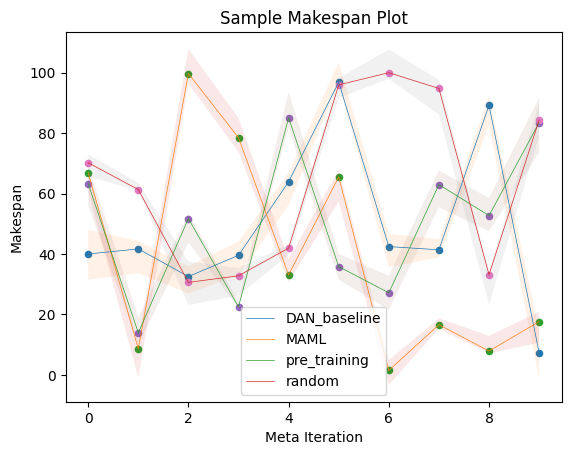

In [31]:
import matplotlib.pyplot as plt

def plot_makespan_fill(data, data_up, data_lb, title):
    # 假设所有方法共享相同的x轴范围
    x = range(len(data[0]))
    print(data[1])
    print(data_up[1])
    print(data_lb[1]) 
    
    # Labels for the lines
    labels = ["DAN_baseline", "MAML", "pre_training", "random"]
    
    # Plotting the lines
    for i, (row, up, lb) in enumerate(zip(data, data_up, data_lb)):
        # 绘制线条并且指定线条宽度
        plt.plot(x, row, label=labels[i], linewidth=0.5)
        # 绘制数据点
        plt.scatter(x, row, s=20)  # s 参数控制点的大小
        # 使用fill_between添加阴影部分
        plt.fill_between(x, lb, up, alpha=0.1)
    
    plt.xlabel("Meta Iteration")
    plt.ylabel("Makespan")
    plt.title(title)
    plt.legend()
    plt.show()

# 示例数据
import numpy as np
meta_iterations = 10  # Meta iterations 的数量
methods = 4  # 方法的数量
data = [np.random.uniform(low=0, high=100, size=meta_iterations).tolist() for _ in range(methods)]
data_up = [np.array(row) + np.random.uniform(low=0, high=10, size=meta_iterations).tolist() for row in data]
data_lb = [np.array(row) - np.random.uniform(low=0, high=10, size=meta_iterations).tolist() for row in data]

# 调用函数绘图
plot_makespan_fill(data, data_up, data_lb, "Sample Makespan Plot")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


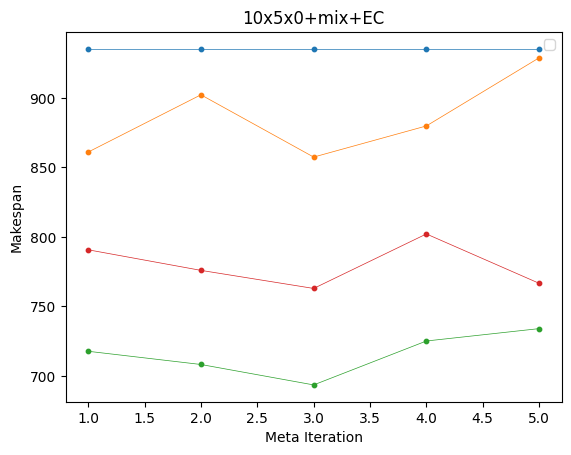

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


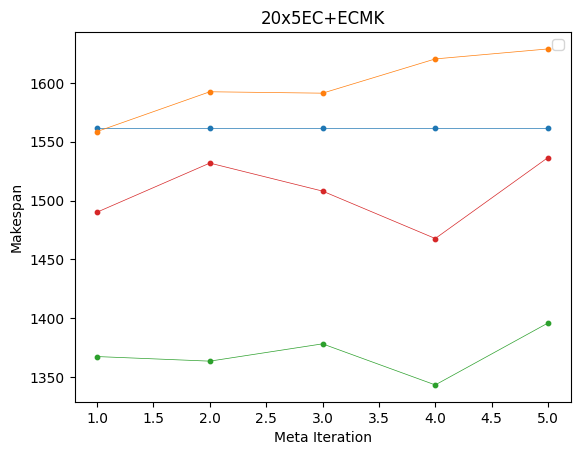

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


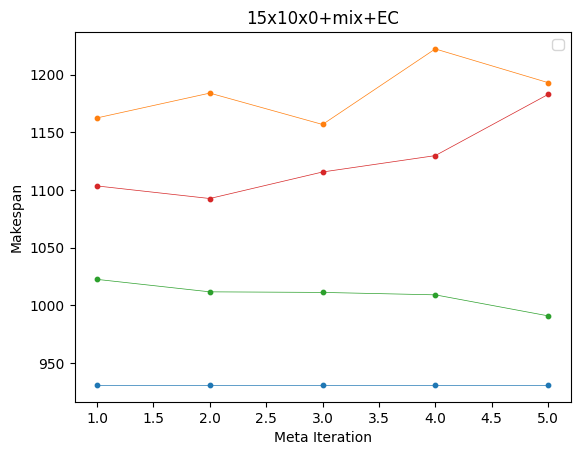

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


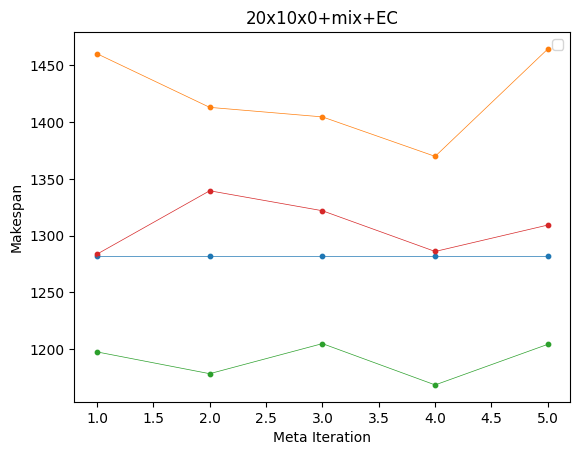

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


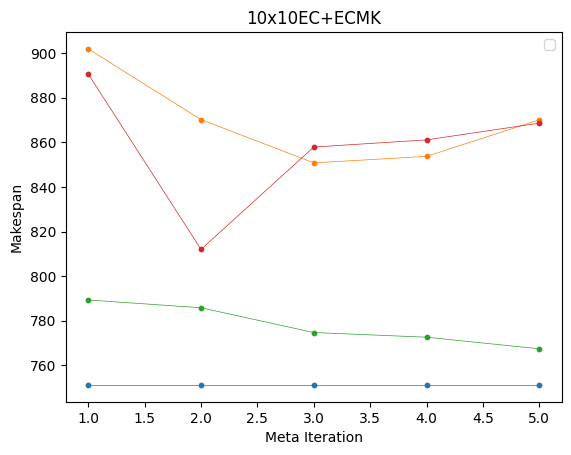

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


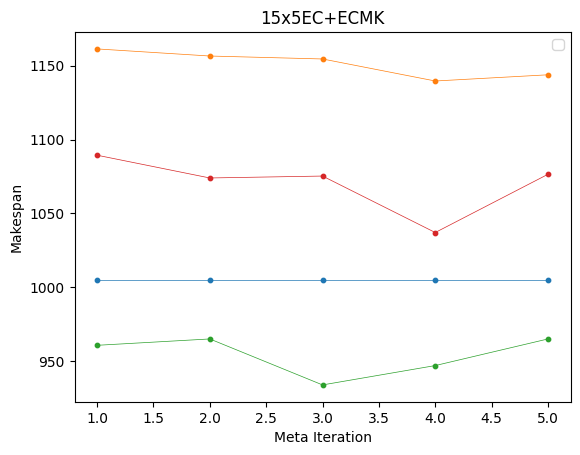

In [43]:

for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    # plot_dict[key][0] = np.full(5, baseline_makespans[idx])
    # plot_dict[key][1] = maml_finetuning_makespans[idx]
    # plot_dict[key][2] = pretrain_finetuning_makespans[idx]
    # plot_dict[key][3] = random_finetuning_makespans[idx]
    # plot_makespan_fill(
    #     [np.full(5, baseline_makespans[idx]), maml_finetuning_makespans[idx].mean(axis=0), pretrain_finetuning_makespans[idx].mean(axis=0), random_finetuning_makespans[idx].mean(axis=0)],
    #     [np.full(5, baseline_makespans[idx]), maml_finetuning_makespans[idx].max(axis=0), pretrain_finetuning_makespans[idx].max(axis=0), random_finetuning_makespans[idx].max(axis=0)],
    #     [np.full(5, baseline_makespans[idx]), maml_finetuning_makespans[idx].min(axis=0), pretrain_finetuning_makespans[idx].min(axis=0), random_finetuning_makespans[idx].min(axis=0)],
    #     key,
    # )
    plot_funetuning([np.full(5, baseline_makespans[idx]), maml_finetuning_makespans[idx].mean(axis=0), pretrain_finetuning_makespans[idx].mean(axis=0), random_finetuning_makespans[idx].mean(axis=0)],key)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


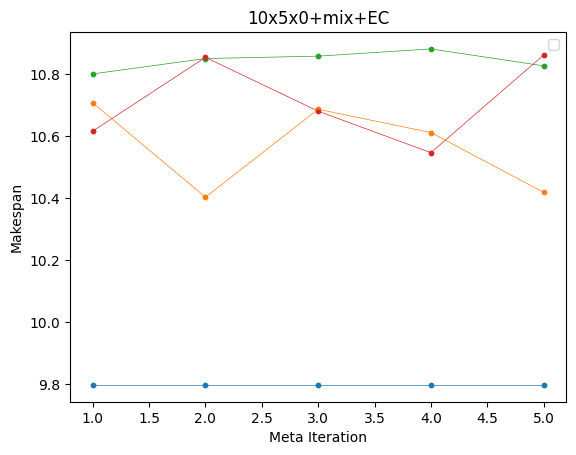

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


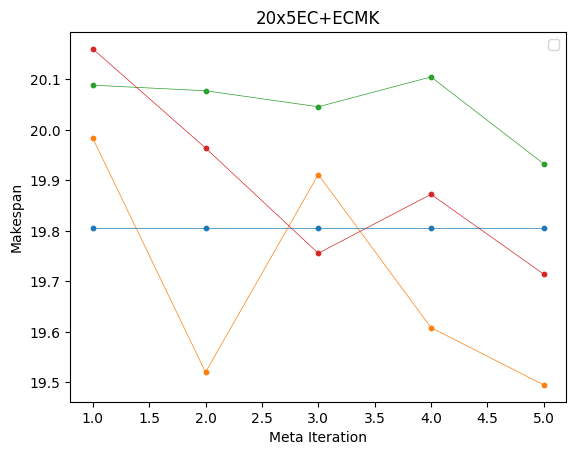

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


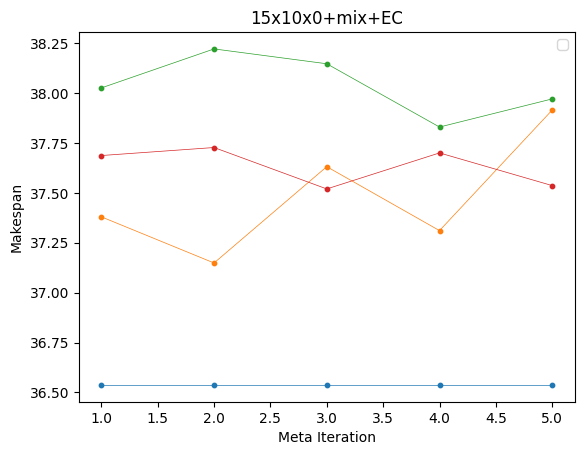

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


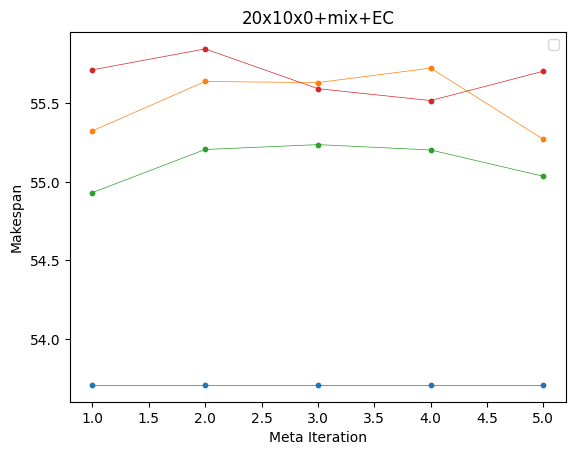

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


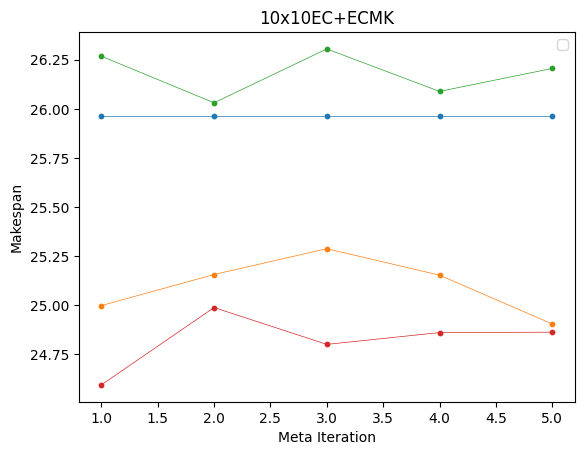

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


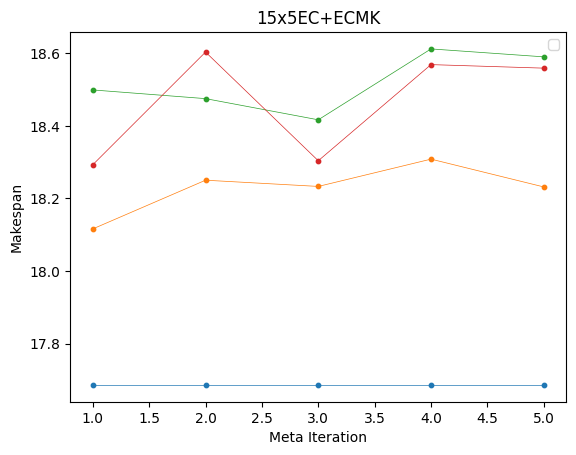

In [44]:

for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    plot_dict[key][0] = np.full(5, baseline_EC[idx])
    plot_dict[key][1] = maml_finetuning_ecs[idx]
    plot_dict[key][2] = pretrain_finetuning_ecs[idx]
    plot_dict[key][3] = random_finetuning_ecs[idx]
    # plot_makespan_fill(
    #     [np.full(5, baseline_EC[idx]), maml_finetuning_ecs[idx].mean(axis=0), pretrain_finetuning_ecs[idx].mean(axis=0), random_finetuning_ecs[idx].mean(axis=0)],
    #     [np.full(5, baseline_EC[idx]), maml_finetuning_ecs[idx].max(axis=0), pretrain_finetuning_ecs[idx].max(axis=0), random_finetuning_ecs[idx].max(axis=0)],
    #     [np.full(5, baseline_EC[idx]), maml_finetuning_ecs[idx].min(axis=0), pretrain_finetuning_ecs[idx].min(axis=0), random_finetuning_ecs[idx].min(axis=0)],
    #     key,
    # )
    plot_funetuning([np.full(5, baseline_EC[idx]), maml_finetuning_ecs[idx].mean(axis=0), pretrain_finetuning_ecs[idx].mean(axis=0), random_finetuning_ecs[idx].mean(axis=0)], key)

